# CFA Audio Chunk Classification
The purpose of this notebook is to put learnings from the [fast.ai course](https://course.fast.ai/) part #1, chapter #1 into practice by classifying audio chunks into several categories.

While this is a slight departure from the course instructions, it has the benefit of having a real world use case for a side project I would like to build.
The key difference is that part #1, chapter #1 targets images as the input data for classification, whereas this notebook uses audio, that is translated to images (mel spectrogram) prior to image classification.

This approach may or may not be the correct way to do things, but it's a fun experiment ;)

## Domain background
Communications between firefighters and the [ESTA Dispatch](https://www.esta.vic.gov.au/) (known as "Firecom" formally, and occasionally still referred to as "VicFire") are captured and streamed by the service: [broadcastify](https://www.broadcastify.com/).

Historical recordings are also available in `mp3` format to broadcastify subscribers.

There is also a test tone emitted into the audio stream on a regular interval to indicate the stream is active even though no spoken traffic may be heard.

## Goal

The goal is to create a machine learning model that is capable of classifing a given audio snippet into one the following categories:

* Test Tone
* Firefighters / Operational Personnel
* Firecom Dispatch (ESTA)
* Composite Firecom & Firefighter (communications are too close to split, eg: < 650ms between utterances)
* Radio Noise / Junk

## Data selection & engineering
A period of approximately one day of audio for the 17th Feb 2023 has been downloaded for District 15 (Ballarat & Surrounds) Country Fire Authority communications from broadcastify.

This was an especially busy day with high radio traffic due to [a significant fire in Bacchus Marsh](https://www.heraldsun.com.au/news/victoria/bacchus-marsh-grassfire-forces-residents-from-homes/news-story/b76d01f1cce176ee85a898971dbeccb4) along with several other incidents.

Once the historical data was downloaded, `pydub` was used to split the audio on silence gaps greater than 650ms and a silence threshold of -70 dB.

A training set was then uploaded to GoogleDrive, manually classified into the above-mentioned catagories.

Additional audio snippets from a diffent, randomly selected day were also uploaded to GoogleDrive and manually classified as "golden files" for validation purposes.

## Motivation
Apart from gaining further knowladge of machine learning, the audio classified by this model can then be subsequently translated to text via ASR (avoiding processing of test tones).

The end game is to be able to display an "SMS style" conversation between firefighters and Firecom in real time, as the audio is streamed from broadcastify.

## External dependencies

In [1]:
# Don't run this cell when running locally, use poetry to install dependencies
!pip install zipfile36 requests numpy scikit-image librosa
!pip install -Uqq fastai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.7 MB/s eta 0:00:00
  Attempting uninstall: soundfile
    Found existing installation: soundfile 0.11.0
    Uninstalling soundfile-0.11.0:
      Successfully uninstalled soundfile-0.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
wfdb 4.1.0 requires SoundFile<0.12.0,>=0.10.0, but you have soundfile 0.12.1 which is incompatible.


In [2]:
## Imports & Constants
import os
import sys
import requests
import IPython
import numpy as np
import matplotlib.pyplot as plt
import zipfile36 as zipfile
import librosa
from PIL import Image
import skimage.io
from fastai.data.all import *
from fastai.vision.all import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

SNIPPET_FILE_BASE_DIR = "cfa-scanner-snippets"
HOP_LENGTH = 256
AUDIO_SAMPLES = {
    'test-tone': '1pkEMHMm6f3sdTfVGPfPgEulRGT1-WwwJ',
    'human-firefighter': '1sQ8qw4fy4kAYAQ1YiKCbagXso2sDK90J',
    'human_firecom': '1R5EX4zjtZTvRP1PKmNF3uQJJt2SbqrLf',
    'human-composite': '1WDvcTPgxZGJQUqZ3UveUiNb4sMP91Ud0',
    'radio-noise': '11w59smE9_oXpIJQrINrNwN2vNe8F8b-l'
}

GOLDEN_FILE_BASE_DIR = "cfa-scanner-golden-files"
GOLDEN_FILES = [ # Not seen by model training, used for validation only
    {'category':  'test-tone',         'id': '1lOU9JHX7UYUPYeDLv9FipGoa53SfIej3', 'expect': True},
    {'category':  'human-firefighter', 'id': '15b7maZvsck8FLhO0osOdRIKnl2sMXDzQ', 'expect': True},
    {'category':  'human-firecom',     'id': '1LRQ55pQkKZ3U5oPOEt9iFFiaBx6v5N2f', 'expect': True},
    {'category':  'human-firecom',     'id': '15b7maZvsck8FLhO0osOdRIKnl2sMXDzQ', 'expect': False},
    {'category':  'human-composite',   'id': '1B6FTnti0pem9Rn0HAkp_H0OGjkKtokFS', 'expect': True},
]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Helper functions

In [3]:
def _get_gdrive_object(id: str) -> requests.models.Response:
    """Get a file object from Google Drive by ID"""
    r = requests.get(f"https://drive.google.com/uc?id={id}")
    return r.content

def gdrive_audio_display(id: str) -> IPython.display.Audio:
    """Get audio file from a Google Drive by ID and return a display"""
    return IPython.display.Audio(_get_gdrive_object(id))

def gdrive_file_download(id: str, output_filename: str = None) -> None:
    """Download a file from Google Drive by ID and save locally"""
    file_data = _get_gdrive_object(id)
    with open(output_filename, "wb") as fh:
        fh.write(file_data)

def scale_minmax(X, min=0.0, max=1.0):
    """Rescale an array to be between min and max"""
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def compute_mel_spectrogram(audio_path, save_file=False, n_fft=1024, hop_length=256, n_mels=40):
    """Compute a mel spectrogram from an audio file and optionally save as an image"""
    audio, sr = librosa.load(audio_path)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    if save_file is not False:
        img = scale_minmax(mel_spec_db, 0, 255).astype(np.uint8)
        img = np.flip(img, axis=0) # put low frequencies at the bottom in image
        skimage.io.imsave(save_file, img)
    return mel_spec_db

def build_sample_set(parent_path) -> dict:
    sample_set = {}
    for category in os.scandir(parent_path):
        if category.is_dir():
            sample_set[category.name] = {'audio': [], 'image': []}
            for audio_file in os.scandir(f'{parent_path}/{category.name}'):
                if str(audio_file.name).endswith('.mp3'):
                    input_audio_file = f'{parent_path}/{category.name}/{audio_file.name}'
                    output_image_file = input_audio_file.replace('.mp3', '.png')
                    sample_set[category.name]['audio'].append(input_audio_file)
                    compute_mel_spectrogram(audio_path=input_audio_file, save_file=output_image_file)
                    sample_set[category.name]['image'].append(output_image_file)
    return sample_set

def get_image_files(parent_path: str) -> list:
    """Get a list of image files from the sample set"""
    sample_set = build_sample_set(parent_path)
    files = []
    for category, _ in sample_set.items():
        files += sample_set[category]['image']
    return files

def get_parent_label(filename):
    """Get the parent directory name from a filename"""
    return str(filename).split("/")[1]

def predict_gdrive_audio_file(audio_file_id, category, expected, model):
    """Download an audio file from Google Drive by ID, predict the category and display the result"""
    fname = f'{GOLDEN_FILE_BASE_DIR}/{category}/{audio_file_id}.mp3'
    os.makedirs(os.path.dirname(fname), exist_ok=True)
    gdrive_file_download(id=audio_file_id, output_filename=fname)
    image_file = fname.replace('.mp3', '.png')
    compute_mel_spectrogram(audio_path=fname, save_file=image_file, hop_length=HOP_LENGTH)

    classification, _ ,probability = model.predict(image_file)
    if classification == category and expected == True or classification != category and expected == False:
        status = "correctly classified"
    else:
        status = "misclassified"

    print(f"Audio File    : {fname}")
    print(f"Category      : {category}")
    print(f"Expected      : {expected}")
    print(f"Classified as : {classification} ({status})")
    print(f"Probability   : {probability[0]:.4f}")
    IPython.display.display(IPython.display.Audio(fname))
    return classification, probability[0]

## Data samples

In [4]:
IPython.display.display(gdrive_audio_display(id=AUDIO_SAMPLES['test-tone']))
IPython.display.display(gdrive_audio_display(id=AUDIO_SAMPLES['human-firefighter']))
IPython.display.display(gdrive_audio_display(id=AUDIO_SAMPLES['human_firecom']))
IPython.display.display(gdrive_audio_display(id=AUDIO_SAMPLES['human-composite']))
IPython.display.display(gdrive_audio_display(id=AUDIO_SAMPLES['radio-noise']))

## Download audio files for local processing

In [5]:
zip_name = f'./{SNIPPET_FILE_BASE_DIR}.zip'
gdrive_file_download(id='1UbZQJ0njsGYBZVURylyVTE_I8o6KuEzL', output_filename=zip_name)

with zipfile.ZipFile(zip_name, "r") as zip_ref:
    zip_ref.extractall(".")
os.remove(zip_name)

## Examine an audio sample waveform

`cfa-scanner-snippets/human-firecom/202302170507-806596-18997_66_dB--14.mp3`

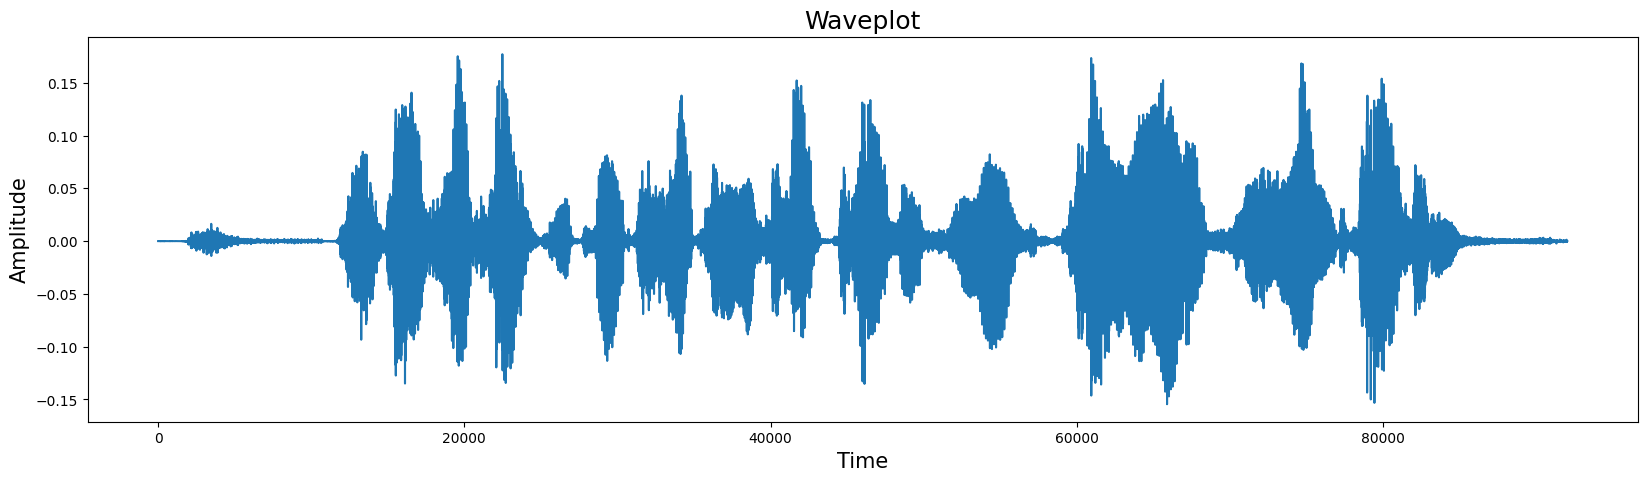

Audio sample rate: 22050


In [6]:
examine_file = f'{SNIPPET_FILE_BASE_DIR}/human-firecom/202302170507-806596-18997_66_dB--14.mp3'
signal, sr = librosa.load(examine_file)

plt.figure(figsize=(20, 5))
plt.plot(signal)
plt.title('Waveplot', fontdict=dict(size=18))
plt.xlabel('Time', fontdict=dict(size=15))
plt.ylabel('Amplitude', fontdict=dict(size=15))
plt.show()
IPython.display.Audio(examine_file)
print(f'Audio sample rate: {sr}')
IPython.display.Audio(examine_file)

## Create and examine a 'mel spectrogram' image

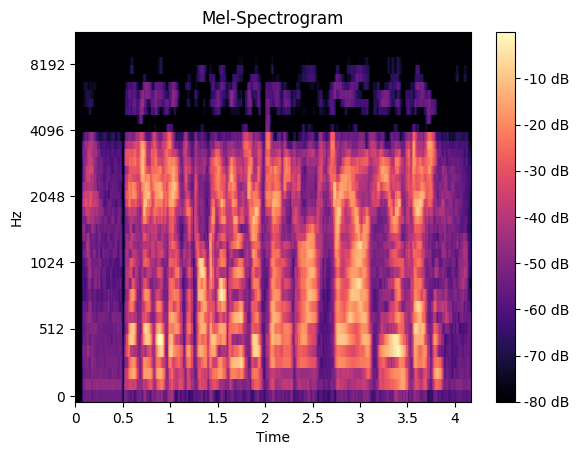

In [7]:
mel_spectrogram = compute_mel_spectrogram(
    audio_path=examine_file,
    save_file=examine_file.replace('.mp3', '.png'),
    hop_length=HOP_LENGTH
)

librosa.display.specshow(mel_spectrogram, x_axis='time', y_axis='mel', sr=sr, hop_length=HOP_LENGTH)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.show()

## Create a mel spectrogram representation of each audio file

audio files: 25 image files: 25 in category: human-composite
audio files: 82 image files: 82 in category: human-firefighter
audio files: 54 image files: 54 in category: human-firecom
audio files: 8 image files: 8 in category: radio-noise
audio files: 19 image files: 19 in category: test-tone


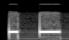

In [8]:
sample_set = build_sample_set(SNIPPET_FILE_BASE_DIR)
for category, _ in sample_set.items():
    print(f"audio files: {len(sample_set[category]['audio'])} image files: {len(sample_set[category]['image'])} in category: {category}")

IPython.display.display(IPython.display.Audio(sample_set['test-tone']['audio'][-1]))
IPython.display.display(IPython.display.Image(sample_set['test-tone']['image'][-1]))

## Create a fast-ai 'DataBlock' and inspect the batch

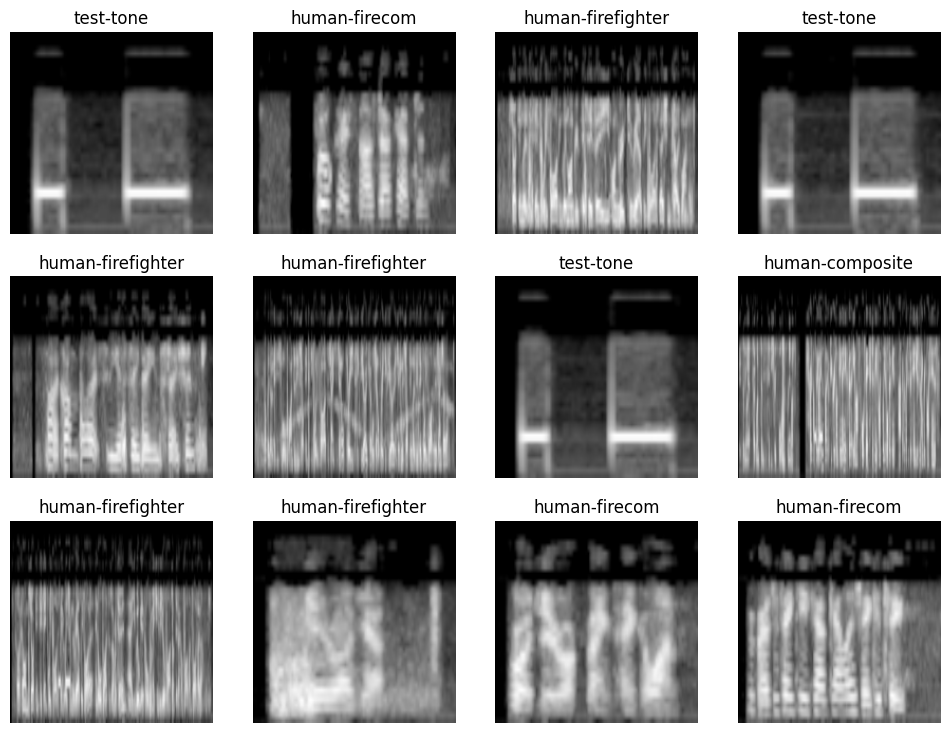

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(SNIPPET_FILE_BASE_DIR, bs=32)

dls.show_batch(max_n=12)

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(16)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 211MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,2.607275,2.693108,0.891892,00:11


epoch,train_loss,valid_loss,error_rate,time
0,1.335264,2.186156,0.783784,00:16
1,1.055115,1.694806,0.648649,00:16
2,0.827148,1.372268,0.540541,00:15
3,0.674603,1.139041,0.405405,00:16
4,0.546868,0.889521,0.351351,00:15
5,0.444857,0.614256,0.216216,00:16
6,0.370447,0.495086,0.162162,00:15
7,0.313839,0.443040,0.189189,00:16
8,0.268801,0.452233,0.189189,00:15
9,0.233182,0.429746,0.162162,00:16


## Can the golden files be correctly classified?

In [11]:
for item in GOLDEN_FILES:
    predict_gdrive_audio_file(audio_file_id=item['id'], category=item['category'], expected=item['expect'], model=learn)

Audio File    : cfa-scanner-golden-files/test-tone/1lOU9JHX7UYUPYeDLv9FipGoa53SfIej3.mp3
Category      : test-tone
Expected      : True
Classified as : test-tone (correctly classified)
Probability   : 0.0001


Audio File    : cfa-scanner-golden-files/human-firefighter/15b7maZvsck8FLhO0osOdRIKnl2sMXDzQ.mp3
Category      : human-firefighter
Expected      : True
Classified as : human-firefighter (correctly classified)
Probability   : 0.0018


Audio File    : cfa-scanner-golden-files/human-firecom/1LRQ55pQkKZ3U5oPOEt9iFFiaBx6v5N2f.mp3
Category      : human-firecom
Expected      : True
Classified as : human-firecom (correctly classified)
Probability   : 0.0756


Audio File    : cfa-scanner-golden-files/human-firecom/15b7maZvsck8FLhO0osOdRIKnl2sMXDzQ.mp3
Category      : human-firecom
Expected      : False
Classified as : human-firefighter (correctly classified)
Probability   : 0.0018


Audio File    : cfa-scanner-golden-files/human-composite/1B6FTnti0pem9Rn0HAkp_H0OGjkKtokFS.mp3
Category      : human-composite
Expected      : True
Classified as : human-composite (correctly classified)
Probability   : 0.9974


## Export the model for later use

In [12]:
learn.export('cfa-district15-utterance-classifier.pkl')

## Conclusion

The model seems to be very effective, however the 'probability' scores are very low, not sure why.

I might experiment with training data augmentation, and different training epoch quantities